# Implementação de Redes Neurais Perceptron Simples

- Hendy Rodrigues F. Silva
- Mat: 1510081

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import random as rnd
from random import randint

warnings.filterwarnings('ignore')

ds_or = pd.read_csv('dataset/ds_or_gate.csv')
ds_t = pd.read_csv('dataset/ds_t.csv')
ds_iris = pd.read_csv('dataset/iris.csv')

ds_derm = pd.read_csv('dataset/dermatology.csv')
ds_derm.drop(['age'], axis=1,inplace=True) # Descarta a IDADE
ds_derm.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,focal_hypergranulosis,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,0,3,0,0,0,1,0,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,1
2,2,1,2,3,1,3,0,3,0,0,...,2,0,2,3,2,0,0,2,3,3
3,2,2,2,0,0,0,0,0,3,2,...,0,3,0,0,0,0,0,3,0,1
4,2,3,2,2,2,2,0,2,0,0,...,2,2,3,2,3,0,0,2,3,3


### Variaveis Auxiliares

In [2]:
last_col = ds_derm.columns[len(ds_derm.columns)-1]
classes = list(ds_derm[last_col].unique())

### Implementação do Perceptron Simples

Foi pego um dataset e criado 1 neuronio para cada classe usando codificacao ONE HOT.
Ele escolhe o dataset de treino 80% de cada classe e reembaralha.

In [3]:
# Calculo do Neuronio
# W(T)*X = u
# x0*w0 + x1*w1 + x2*w2 ... + xp*wp = u
# Returned:
# S = { u >= 0 -> Y = 1 | u < 0 -> Y = 0 }
def calculate_neuron(X, W):
    u = W.dot(X.T) # It makes X*W(T)
    y = 1 if u >= 0 else 0 # If u > 0 then y = 1 if not, y = 0
    return y

#Calculo do Erro
# e = d - y
def calculate_error(Y, Expected):
    error = Expected - Y
    return error

#Calcular novo peso(W) do neuronio
# 𝒘(𝑡 + 1) = 𝒘 (𝑡) + 𝜂*𝑒(𝑡)*𝒙(𝑡)
def calculate_new_w(X, Y, W, Expected, rate):
    w_new = W + rate * calculate_error(Y, Expected) * X
    return w_new

# One Hot Codification
# Codificacao usando arrays de zeros e um para cada classe
def one_hot_encoding(classes):
    cl_onehot = np.zeros((len(classes),len(classes)),dtype=int)
    np.fill_diagonal(cl_onehot,1)
    r = [(classes[i], cl) for i, cl in enumerate(cl_onehot)]
    return r

# Codifica as classes esperadas
def encode_expected(expected, encoded_class):
    return [ list(filter(lambda e: e[0] == x, encoded_class))[0][1] for x in expected ]

# Pega a matriz de W da rede e aplica a matriz de frobenius
# |A|frob = raiz ( tr(Transp(A)*A) )
def frob_matrix(W, W_old):
    W = np.array(W)
    W_old = np.array(W_old)
    A = W - W_old
    f = np.sqrt(np.trace( A.T.dot(A) ))
    return f

# Codifica todas as classes do dataset
def encode_class(ds):
    return one_hot_encoding(pd.unique(ds.iloc[:,-1:].values.flatten()))

# Decodifica o resultado
def decode_result(encoded_class, value):
    if sum(value) != 1:
        value = list(encoded_class[randint(0,len(encoded_class)-1)][1])
    return list(filter(lambda x: list(x[1]) == value,encoded_class))[0][0]

# Pega o conjunto de pesos W(i,j) e calcula todos os neuronios da Rede
def calculate_network(input_, Ws):
    return [ calculate_neuron(np.array([-1] + input_),Wc) for Wc in Ws ]

# Pega o conjunto de pesos W(i,j), conjunto de inputs e as classes codificadas e retorna o valor final 
def neural_network(W, X, encoded_class):
    network_result = calculate_network(X,W)
    result = decode_result(encoded_class,network_result)
    return result

# Perceptron Simples
# Monta todo o aprendizado do perceptron simples e retorna o conjunto de pesos W(i,j)
def mount_neural_network(ds, wInit, rate, encoded_class):
    nds = ds.sample(frac=1, random_state=randint(0,15100)) # Embaralha todo o dataset
    
    expected = nds.iloc[:,-1:].values.flatten() # Pega os valores esperados
    expected_encoded = encode_expected(expected, encoded_class) # Codifica os valores esperados
    
    ds_no_class = nds.iloc[:,:-1] # Retira a ultima coluna
    ds_no_class.insert(0, 'bias', -1)
    
    # Inicializa o conjunto de peso W(i,j) com todos com o valor de wInit que foi recebido na função
    W_ALL = np.array([wInit.copy() for i in range(0, len(encoded_class))])
    
    i = 0
    while True: # Condicão de parada logo no final do WHILE
        #print('\n+++++++++++++++++++++++ Rodada N: '+ str(i+1) + ' +++++++++++++++++++++++')
        W_old = W_ALL.copy()
        for e in range(0, len(encoded_class)): # Executa esse for representando cada neuronio (Um neuronio por classe)
            W = W_ALL[e] # conjunto de pesos daquele neuronio W(i)
            X = ds_no_class.values[i % len(expected)] # Valor recebido X(i)
            y = calculate_neuron(np.array([X]), W) # Resultado do neuronio
            
            exp = expected_encoded[i % len(expected)][e] # Pega o valor esperado
            
            new_W = calculate_new_w(np.array(X), y,W, exp, rate) # E a partir dos conjuntos X(i), y, W(i), esperado, e rate
            # calcula o novo conjunto de W(i)
            W_ALL[e] = new_W # Substitui no array de conjunto W(i,j)
            
            #print('------------- e n: '+str(e)+' --------------')
            #print('W:' + str(W))
            #print('Entrada (X):' + str(X))
            #print('Achado (Y): '+str(y))
            #print('Esperado (Expected): '+str(exp))
            #print(W_ALL)
            
        i += 1
        # Condiçao de parada: |Delta W|Frob = 0 E i maior que tamanho de linhas do DataSet
        if frob_matrix(W_ALL, W_old) == 0 and ds.shape[0] < i : 
            break
    return W_ALL


#### Treinar
Executa o Perceptron e faz as contagens de erros e acertos

In [4]:
def train(dataset_train, dataset_test):
    count_correct = 0
    count_incorrect = 0
    
    count_by_classes_correct = [0 for i in range(0,len(classes))]
    count_by_classes_incorrect = [0 for i in range(0,len(classes))]
    
    # Codifica as classes do dataset
    encoded_class = encode_class(dataset_train)
    
    #Monta o conjunto de pesos W(i,j)
    network = mount_neural_network(dataset_train,[rnd.random() for x in list(ds_derm.columns)], 0.5,encoded_class)
    
    for index, row in dataset_test.iterrows():
        
        tuple_t = list(row)
        tuple_t.pop()
        result = neural_network(network,tuple_t,encoded_class) # Efetua o resultado pelo valor da rede
        
        #Result
        if result == row[last_col]:
            count_correct += 1
            count_by_classes_correct[classes.index(result)] += 1
        else:
            count_incorrect += 1
            count_by_classes_incorrect[classes.index(result)] += 1
        
    return (count_correct, count_incorrect, count_by_classes_correct, count_by_classes_incorrect)

#### Separar dataset por classes
Essa função pega o dataset, separa por classe e divide em teste e treino de acordo com a porcentagem.
No final concatena datasets de treinos e testes.

In [5]:
def seperate_ds_by_class(dataset, percentage):
    rds_train = pd.DataFrame()
    rds_test = pd.DataFrame()
    
    for c in classes:
        nds = dataset[dataset[last_col]==c]
        
        # Essa função pega o dataset e separa uma fração dele, e reordena
        ds_train = nds.sample(frac=percentage, random_state=randint(0,15100))
        # Pega o que sobrou do dataset de treino
        ds_test = nds.drop(ds_train.index) 
        
        rds_train = rds_train.append(ds_train)
        rds_test = rds_test.append(ds_test)
        
    rds_train = rds_train.reset_index() # Reiniciar indice
    rds_test = rds_test.reset_index() # Reiniciar indice

    rds_train.drop('index',1,inplace=True) # Retirar coluna index
    rds_test.drop('index',1,inplace=True) # Retirar coluna index
    
    return (rds_train, rds_test)

#### Treinar e Testar
O algoritmo para implementar o K-NN, foi utilizando interando todos o dataset de ``teste`` e fazendo K-NN pela formula euclidiana e pegando o k-esimo ponto mais próximo para decidir qual a classe.
Com o resultado desse dado eu faço a verificação com cada dataset de teste da interação

In [6]:
def run_nth(ds,percentage, number):
    percentages_correct = list()
    prob_correct_by_class = []
    
    for i in range(0,number):
        ds_train, ds_test = seperate_ds_by_class(ds,percentage)
        correct, incorrect, count_by_classes_correct, count_by_classes_incorrect = train(ds_train, ds_test)

        by_class = []
        for count_correct, count_incorrect in zip(count_by_classes_correct, count_by_classes_incorrect):
            if count_correct+count_incorrect != 0:
                by_class.append(count_correct/(count_correct+count_incorrect))
            else:
                by_class.append(0)
                
        prob_correct_by_class.append(by_class)
        percentages_correct.append(correct/(correct+incorrect))
        
    return (percentages_correct, prob_correct_by_class)

### Trata o resultado do treino e teste
Faz o calculo de 80% para teste e 20% para treino de acordo com a quantidade de corretas e incorretas

In [7]:
percents, prob_by_class = run_nth(ds_derm,0.8,30)

### Taxa de Acerto

In [8]:
taxa_acerto_min=np.min(percents)
taxa_acerto_max=np.max(percents)
taxa_acerto_med=np.mean(percents)

print('Taxa de Acerto')
print('--------------')
print('Minimo: ' + str(taxa_acerto_min))
print('Máxima: ' + str(taxa_acerto_max))
print('Média: '+str(taxa_acerto_med))

Taxa de Acerto
--------------
Minimo: 0.75
Máxima: 0.9722222222222222
Média: 0.8787037037037037


### Taxa de Acerto Médio por Classe

In [9]:
print('Taxa de Acerto Médio por classe')
print('-------------------------------')

ar_value = [ np.mean(m) for m in np.array(prob_by_class).transpose() ]

for i, _class in enumerate(ar_value):
    print('Classe \'' +  str(classes[i]) +'\' : ' + str(_class))

Taxa de Acerto Médio por classe
-------------------------------
Classe '2' : 0.8608669108669109
Classe '1' : 0.9523210991906643
Classe '3' : 0.9204547930283226
Classe '5' : 0.8936719761719762
Classe '4' : 0.8318989343989344
Classe '6' : 0.6765873015873017


### Produzir os dados para gerar o gráfico
Nessa parte ele interaje de **80/20** até **20/80** os datasets de treino e teste, a cada porcentagem ele calcula as medias de probabilidade de acerto 30 vezes.

**OBS: ESSE TRECHO DEMORA CERCA DE 15 minutos para executar.**

In [10]:
mean_percents = list()
percents_axis = list()
for n in range(20,81):
    p, pi = run_nth(ds_derm,n/100, 30)
    mean_percents.append(np.mean(p))
    percents_axis.append(n)
    

### Gráfico de acerto
Gráfico contendo a ``Probabilidade de acerto X Porcentagem do dataset de treino``.


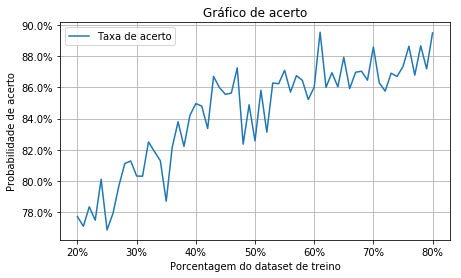

In [11]:
fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)
percents_axis = [x / 100 for x in percents_axis]
ax.plot(percents_axis, mean_percents, label='Taxa de acerto')
ax.set_title('Gráfico de acerto')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Probabilidade de acerto')

ax.set_xlabel('Porcentagem do dataset de treino')

plt.grid(True)
plt.legend()
plt.show()